In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D
import tensorflow.keras.utils 
from tensorflow.keras.utils import to_categorical
from keras import utils as np_utils
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
import seaborn as sn
import matplotlib.pyplot as plt
from keras import backend as K

In [2]:
## Important functions 

## -------------------------------------------------------------------- ##

def F1_Score(y_true, y_pred): 
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

## -------------------------------------------------------------------- ##
def preprocessing(raw, num_classes, im_rows, im_columns):
  out_y = tensorflow.keras.utils.to_categorical(raw.label, num_classes)
  num_images = raw.shape[0]
  x_as_array = raw.values[:,1:]
  x_reshaped = x_as_array.reshape(num_images, im_rows, im_columns, 1)
  normalized_x = x_reshaped / 255

  return normalized_x, out_y

## -------------------------------------------------------------------- ##

def sample_images_data(data):
    sample_images = []
    sample_labels = []
    for k in labels.keys():
        samples = data[data["label"] == k].head(4)

        for j, s in enumerate(samples.values):
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_rows,IMG_cols)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    return sample_images, sample_labels

## -------------------------------------------------------------------- ##

def plot_sample_images(data_sample_images,data_sample_labels,cmap= 'Greys'):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()   

In [3]:
train_file = '/content/drive/MyDrive/Neural Networks & Deep Learning/FashionMNIST/fashion-mnist_train.csv'
test_file = '/content/drive/MyDrive/Neural Networks & Deep Learning/FashionMNIST/fashion-mnist_test.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [4]:
labels = {0 : "T-shirt/top", 
          1: "Trouser", 
          2: "Pullover", 
          3: "Dress", 
          4: "Coat",
          5: "Sandal", 
          6: "Shirt", 
          7: "Sneaker", 
          8: "Bag", 
          9: "Ankle Boot"}

num_classes = 10
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(num_classes)]

In [5]:
IMG_rows = 28
IMG_cols = 28

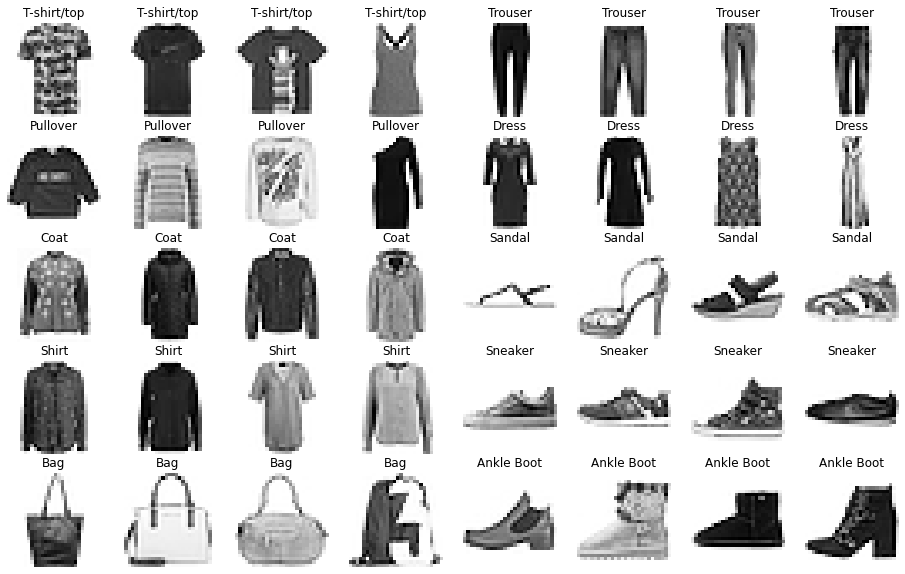

In [7]:
train_sample_images, train_sample_labels = sample_images_data(train_data)
plot_sample_images(train_sample_images,train_sample_labels, 'Greys')

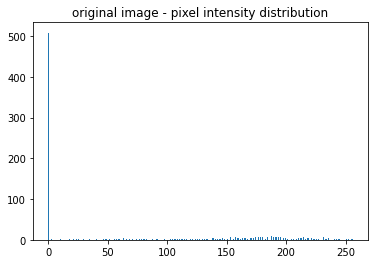

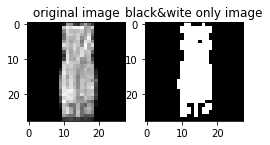

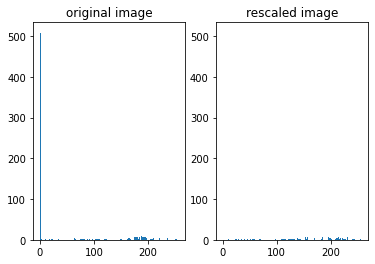

In [8]:
#Pick-up one random image from original training set
i = np.random.randint(low=0, high=42001, size=1).tolist()[0]
pixels = train_data.iloc[i, 1:]
image = train_data.iloc[i, 1:].values.reshape((28,28))

#Pixel intensity hstogram
plt.hist(pixels, bins=256, range=(0,256))
plt.title('original image - pixel intensity distribution')
plt.show()

#Rescaling the intensity
pmin, pmax = image.min(), image.max()
rescaled_image = 255*(image-pmin) / (pmax - pmin)
rescaled_pixels = rescaled_image.flatten()

#Only black or white pixels
bw_pixels = pixels.apply(lambda x: 0 if x<128 else 255)
bw_image = bw_pixels.values.reshape((28,28))

#Visual comparison of images
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.subplot(1, 3, 2)
plt.imshow(bw_image, cmap='gray')
plt.title('black&wite only image')
plt.show()

#Visual Histogram comparison
plt.subplot(1, 2, 1)
plt.hist(pixels, bins=256, range=(0,256))
plt.title('original image')
plt.subplot(1, 2, 2)
plt.hist(rescaled_pixels, bins=256, range=(0,256))
plt.title('rescaled image')
plt.show()

In [6]:
f = lambda x: 0 if x==0 else 1
new_train = train_data.drop('label', axis = 1).applymap(f)
new_train['label'] = train_data['label']
first_column = new_train.pop('label')
new_train.insert(0, 'label', first_column)

new_test = test_data.drop('label', axis = 1).applymap(f)
new_test['label'] = test_data['label']
first_column_test = new_test.pop('label')
new_test.insert(0, 'label', first_column_test)

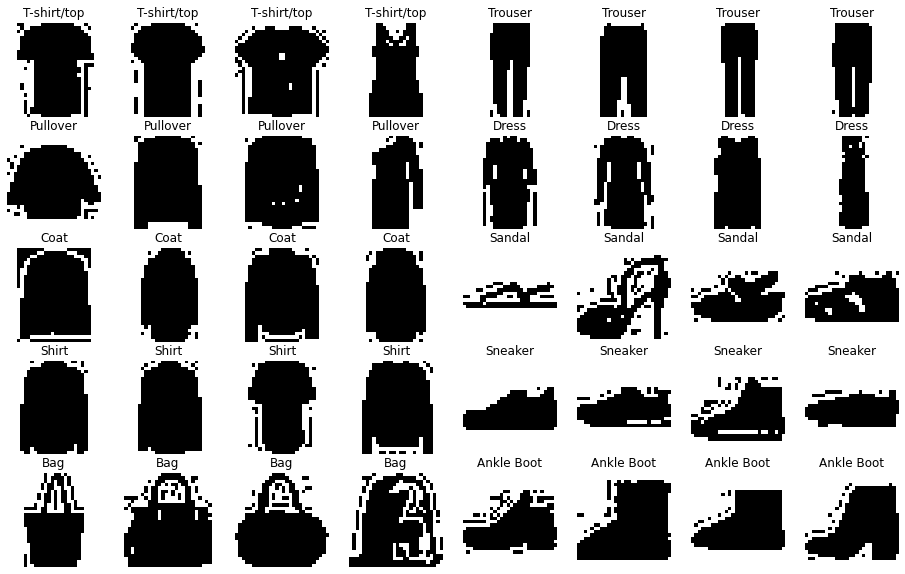

In [11]:
new_train_sample_images, new_train_sample_labels = sample_images_data(new_train)
plot_sample_images(new_train_sample_images,new_train_sample_labels, 'Greys')

In [7]:
combined_train = train_data.append(new_train, ignore_index=True)
combined_test = test_data.append(new_test, ignore_index = True)

In [8]:
combined_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119996,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
119997,8,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
119998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
combined_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,1,0,0,0
19996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0
19997,8,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,0
19998,8,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
num_classes = 10
im_rows = 28
im_columns = 28

In [16]:
x_train_bnw, y_train_bnw = preprocessing(new_train, 10, 28, 28)

In [11]:
def MakeModel():
  model = Sequential()
  model.add( Conv2D(filters= 16, kernel_size=(4,4), padding='Same',activation='relu', input_shape=(28,28,1)) )
  model.add(BatchNormalization())
  
  model.add( Conv2D(filters= 16, kernel_size=(3,3), padding='Same',activation='relu') )
  model.add(BatchNormalization())
  
  model.add( MaxPool2D(pool_size=(2,2)) )
  model.add(Dropout(0.4))

  model.add( Conv2D(filters=32, kernel_size=(3,3), padding='Same',activation='relu') )
  model.add(BatchNormalization())
  model.add( Conv2D(filters=64, kernel_size=(2,2), padding='Same',activation='relu') )
  model.add(BatchNormalization())
  model.add( MaxPool2D(pool_size=(2,2)) )
  model.add(Dropout(0.4))
  
  model.add( Conv2D(filters=128, kernel_size=(3,3), padding='Same',activation='relu') )
  model.add(BatchNormalization())
  model.add( Conv2D(filters=256, kernel_size=(2,2), padding='Same',activation='relu') )
  model.add(BatchNormalization())
  model.add( MaxPool2D(pool_size=(2,2)) )
  model.add(Dropout(0.4))
  
  model.add(Flatten())
  
  model.add(Dense(256,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(num_classes,activation='softmax'))
  
  model.summary()
  return model

In [12]:
model = MakeModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        272       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 28, 28, 16)        64        
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',F1_Score])

In [21]:
history=model.fit(x_train_bnw, y_train_bnw, batch_size=64, epochs=50, validation_split=0.25)

Epoch 1/50
704/704 [==============================] - 24s 10ms/step - loss: 0.5988 - accuracy: 0.7734 - F1_Score: 0.7719 - val_loss: 8.3137 - val_accuracy: 0.3577 - val_F1_Score: 0.3583
Epoch 2/50
704/704 [==============================] - 6s 9ms/step - loss: 0.4308 - accuracy: 0.8361 - F1_Score: 0.8347 - val_loss: 0.3455 - val_accuracy: 0.8707 - val_F1_Score: 0.8709
Epoch 3/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3800 - accuracy: 0.8566 - F1_Score: 0.8557 - val_loss: 0.3292 - val_accuracy: 0.8759 - val_F1_Score: 0.8771
Epoch 4/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3511 - accuracy: 0.8659 - F1_Score: 0.8665 - val_loss: 0.3384 - val_accuracy: 0.8737 - val_F1_Score: 0.8753
Epoch 5/50
704/704 [==============================] - 7s 10ms/step - loss: 0.3319 - accuracy: 0.8740 - F1_Score: 0.8741 - val_loss: 0.3290 - val_accuracy: 0.8783 - val_F1_Score: 0.8780
Epoch 6/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3

<Figure size 400x240 with 0 Axes>

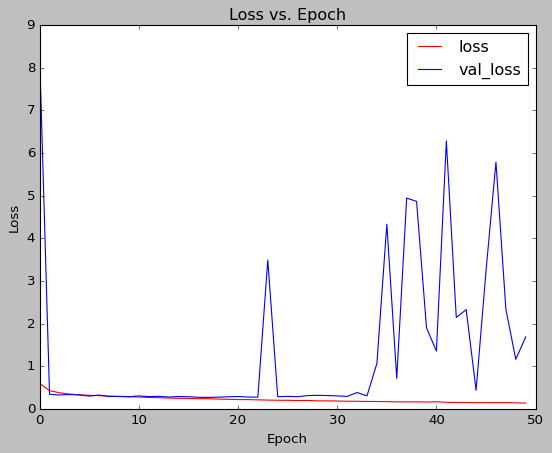

<Figure size 400x240 with 0 Axes>

In [22]:
plt.style.use('classic')
plt.plot(history.history['loss'],'red')
plt.plot(history.history['val_loss'],'blue')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.figure(figsize=(5,3)) 

<Figure size 400x240 with 0 Axes>

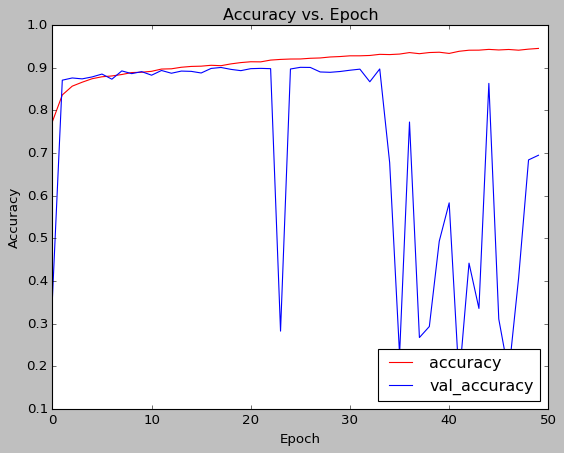

<Figure size 400x240 with 0 Axes>

In [23]:
plt.style.use('classic')
plt.plot(history.history['accuracy'],'red')
plt.plot(history.history['val_accuracy'],'blue')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')

plt.figure(figsize=(5,3)) 

<Figure size 400x240 with 0 Axes>

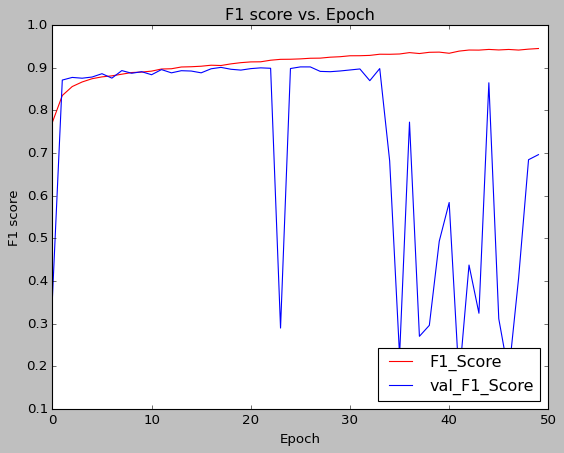

<Figure size 400x240 with 0 Axes>

In [24]:
plt.style.use('classic')
plt.plot(history.history['F1_Score'],'red')
plt.plot(history.history['val_F1_Score'],'blue')
plt.title('F1 score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['F1_Score', 'val_F1_Score'], loc = 'lower right')
plt.figure(figsize=(5,3)) 

In [25]:
x_test_bnw, y_test_bnw = preprocessing(new_test, 10, 28, 28)

In [26]:
score = model.evaluate(x_test_bnw, y_test_bnw, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6224157810211182
Test accuracy: 0.6998999714851379


In [27]:
#get the predictions for the test data
predicted_classes_bnw = model.predict_classes(x_test_bnw)
#get the indices to be plotted
y_true_bnw = np.array(new_test.iloc[:, 0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [30]:
accurate_pred = np.nonzero(predicted_classes_bnw == y_true_bnw)[0]
non_accurate_pred = np.nonzero(predicted_classes_bnw != y_true_bnw)[0]

In [31]:
print(classification_report(predicted_classes_bnw, y_true_bnw))

              precision    recall  f1-score   support

           0       0.12      0.88      0.21       136
           1       0.77      1.00      0.87       765
           2       0.04      0.97      0.07        40
           3       0.92      0.73      0.81      1270
           4       0.49      0.64      0.55       758
           5       0.99      0.89      0.94      1113
           6       0.88      0.31      0.45      2895
           7       0.93      0.92      0.93      1010
           8       0.99      0.87      0.93      1136
           9       0.87      0.99      0.92       877

    accuracy                           0.70     10000
   macro avg       0.70      0.82      0.67     10000
weighted avg       0.86      0.70      0.73     10000



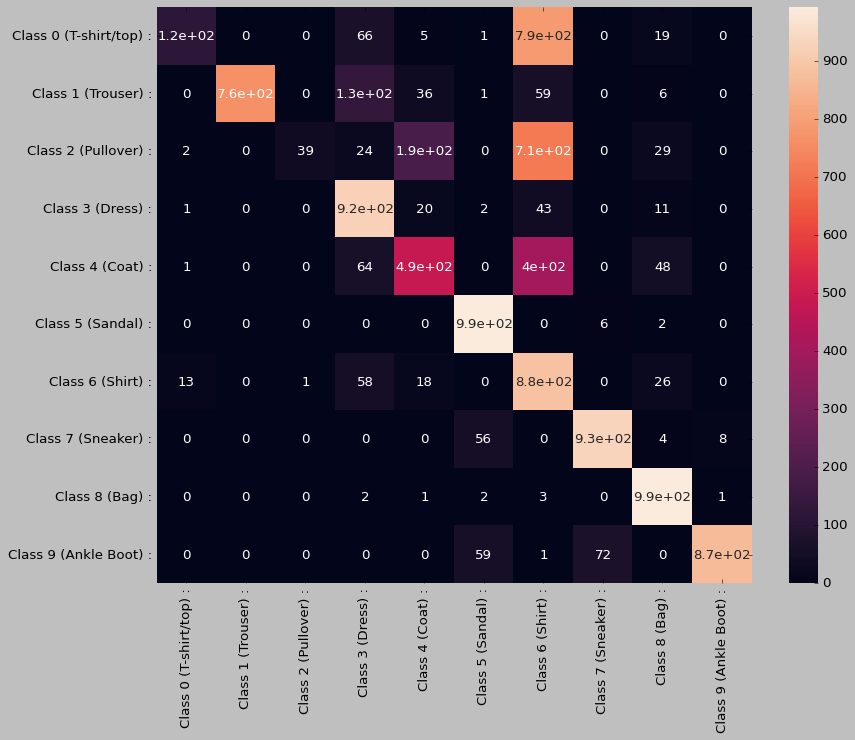

In [32]:
cf = confusion_matrix(np.array(y_true_bnw), predicted_classes_bnw)
df_cm = pd.DataFrame(cf, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True)

In [14]:
x_train_combined, y_train_combined = preprocessing(combined_train, 10, 28, 28)

In [15]:
history_combined = model.fit(x_train_combined, y_train_combined, batch_size=64, epochs=50, validation_split=0.25)

Epoch 1/50
1407/1407 [==============================] - 27s 9ms/step - loss: 0.6318 - accuracy: 0.7608 - F1_Score: 0.7598 - val_loss: 0.6484 - val_accuracy: 0.7514 - val_F1_Score: 0.7451
Epoch 2/50
1407/1407 [==============================] - 14s 10ms/step - loss: 0.4000 - accuracy: 0.8500 - F1_Score: 0.8499 - val_loss: 0.4068 - val_accuracy: 0.8476 - val_F1_Score: 0.8448
Epoch 3/50
1407/1407 [==============================] - 14s 10ms/step - loss: 0.3435 - accuracy: 0.8700 - F1_Score: 0.8708 - val_loss: 0.3654 - val_accuracy: 0.8652 - val_F1_Score: 0.8659
Epoch 4/50
1407/1407 [==============================] - 14s 10ms/step - loss: 0.3110 - accuracy: 0.8833 - F1_Score: 0.8833 - val_loss: 0.3424 - val_accuracy: 0.8715 - val_F1_Score: 0.8719
Epoch 5/50
1407/1407 [==============================] - 12s 9ms/step - loss: 0.2912 - accuracy: 0.8906 - F1_Score: 0.8911 - val_loss: 0.3221 - val_accuracy: 0.8767 - val_F1_Score: 0.8777
Epoch 6/50
1407/1407 [==============================] - 12s 9m

<Figure size 400x240 with 0 Axes>

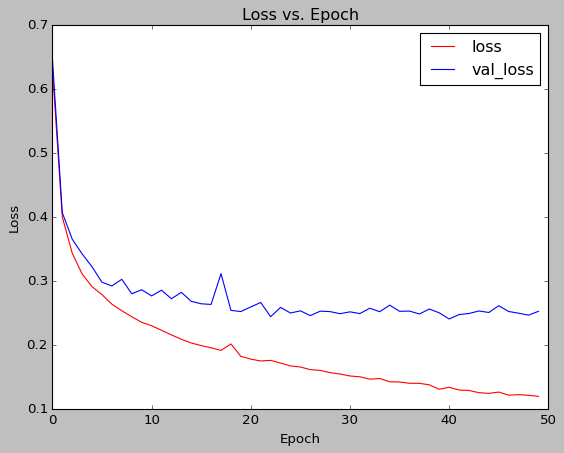

<Figure size 400x240 with 0 Axes>

In [16]:
plt.style.use('classic')
plt.plot(history_combined.history['loss'],'red')
plt.plot(history_combined.history['val_loss'],'blue')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.figure(figsize=(5,3)) 

<Figure size 400x240 with 0 Axes>

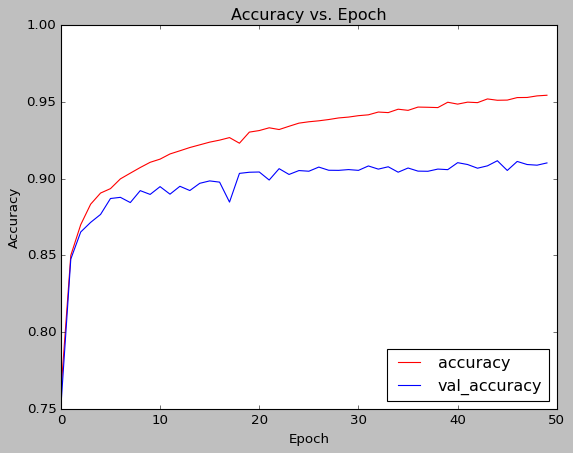

<Figure size 400x240 with 0 Axes>

In [17]:
plt.style.use('classic')
plt.plot(history_combined.history['accuracy'],'red')
plt.plot(history_combined.history['val_accuracy'],'blue')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')

plt.figure(figsize=(5,3)) 

<Figure size 400x240 with 0 Axes>

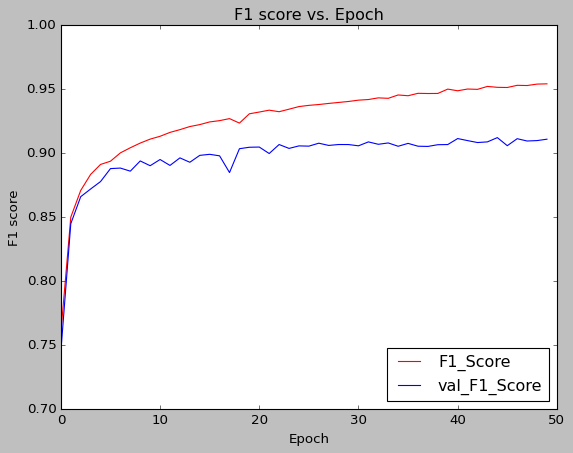

<Figure size 400x240 with 0 Axes>

In [18]:
plt.style.use('classic')
plt.plot(history_combined.history['F1_Score'],'red')
plt.plot(history_combined.history['val_F1_Score'],'blue')
plt.title('F1 score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend(['F1_Score', 'val_F1_Score'], loc = 'lower right')
plt.figure(figsize=(5,3)) 

In [19]:
x_test_combined, y_test_combined = preprocessing(combined_test, 10, 28, 28)

In [20]:
score = model.evaluate(x_test_combined, y_test_combined, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2519306242465973
Test accuracy: 0.92044997215271


In [21]:
#get the predictions for the test data
predicted_classes_combined = model.predict_classes(x_test_combined)
#get the indices to be plotted
y_true_combined = np.array(combined_test.iloc[:, 0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
accurate_pred = np.nonzero(predicted_classes_combined == y_true_combined)[0]
non_accurate_pred = np.nonzero(predicted_classes_combined != y_true_combined)[0]

In [23]:
print(classification_report(predicted_classes_combined, y_true_combined))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2137
           1       0.99      0.99      0.99      2001
           2       0.87      0.85      0.86      2039
           3       0.94      0.95      0.94      1980
           4       0.88      0.85      0.87      2073
           5       0.97      1.00      0.99      1957
           6       0.71      0.81      0.76      1758
           7       0.98      0.95      0.96      2064
           8       1.00      0.99      0.99      2017
           9       0.96      0.98      0.97      1974

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



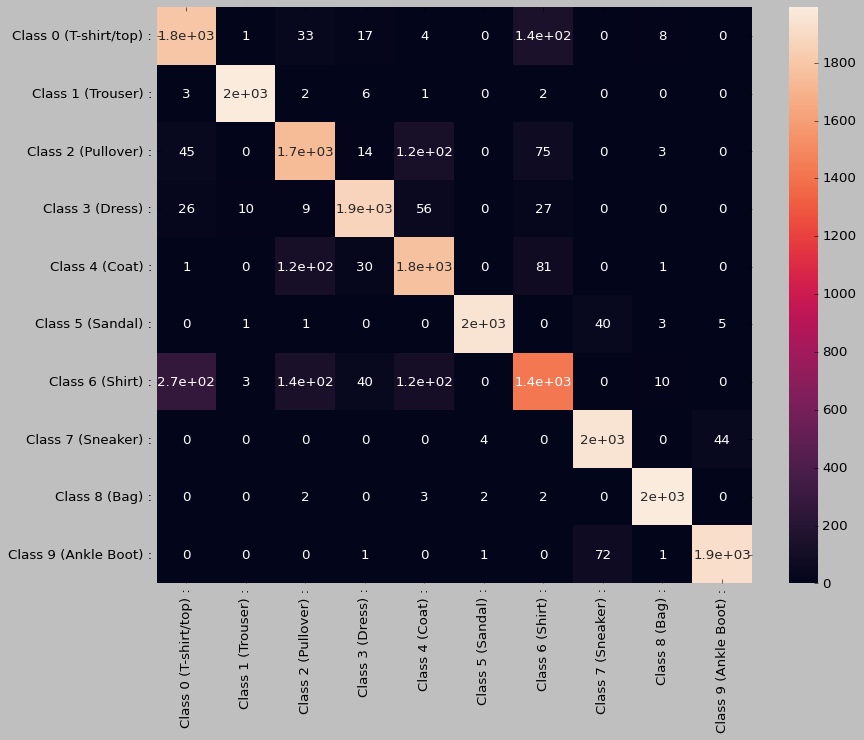

In [24]:
cf = confusion_matrix(np.array(y_true_combined), predicted_classes_combined)
df_cm = pd.DataFrame(cf, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True)